<a href="https://colab.research.google.com/github/fajrunwm/geog0105/blob/main/U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation

## Connect to Google Drive

Mounting Google Drive to access our dataset.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Essential Libraries

In [ ]:
import os  # Operating system interfaces for file handling
import numpy as np  # Numerical operations on large arrays
import tensorflow as tf  # TensorFlow for deep learning
import random  # Generate random numbers
import matplotlib.pyplot as plt  # Plotting and visualization

from sklearn.model_selection import train_test_split  # Splitting the dataset into training and validation sets
from tensorflow.keras.utils import to_categorical  # Convert class vectors to binary class matrices
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate  # Layers for building the U-Net model
from tensorflow.keras.models import Model  # Class to create a Keras model
from tensorflow.keras.optimizers import Adam  # Adam optimizer
from tensorflow.keras.callbacks import EarlyStopping  # Stop training when a monitored metric has stopped improving
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation for image data
from tensorflow.keras.preprocessing.image import load_img, img_to_array  # Functions to load and process images

## Data Loading

In [ ]:
# Function to load images and masks from directories
def load_images_and_masks(image_dir, mask_dir, target_size=(256, 256)):
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
    mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])

    images = []
    masks = []

    for img_file, mask_file in zip(image_files, mask_files):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, mask_file)

        img = load_img(img_path, target_size=target_size)
        mask = load_img(mask_path, target_size=target_size, color_mode="grayscale")

        img = img_to_array(img) / 255.0  # Normalize image
        mask = img_to_array(mask)  # Do not normalize mask for discrete class values

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

In [ ]:
image_dir = 'drive/MyDrive/Colab Notebooks/GEOG0105/ML_UIS/dataset/images'
mask_dir = 'drive/MyDrive/Colab Notebooks/GEOG0105/ML_UIS/dataset/masks'
images, masks = load_images_and_masks(image_dir, mask_dir)

In [ ]:
# Verify the lengths of images and masks
print(f"Number of images: {len(images)}")
print(f"Number of masks: {len(masks)}")

Number of images: 5
Number of masks: 5


In [ ]:
# Verify File Existence
# List files in directories
image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
mask_files = [f for f in os.listdir(mask_dir) if f.endswith('.png')]

# Print out the lists of files
print("Image files:", image_files)
print()
print("Mask files:", mask_files)

Image files: ['img_patch_7_12.png', 'img_patch_6_13.png', 'img_patch_0_5.png', 'img_patch_0_6.png', 'img_patch_0_4.png']

Mask files: ['label_patch_6_13.png', 'label_patch_7_12.png', 'label_patch_0_5.png', 'label_patch_0_6.png', 'label_patch_0_4.png']


## Data Visualisation

In [ ]:
# Function to extract unique values from masks
def get_unique_values(masks):
    unique_values = set()
    for mask in masks:
        unique_values.update(np.unique(mask))
    return unique_values

# Function to generate unique labels based on mask unique values
def get_unique_labels(mask_values):
    return [f"Label {int(val*255)}" for val in mask_values]

Unique Labels: ['Label 0', 'Label 38', 'Label 75']
Unique Mask Values: {0.0, 0.14901961, 0.29411766}


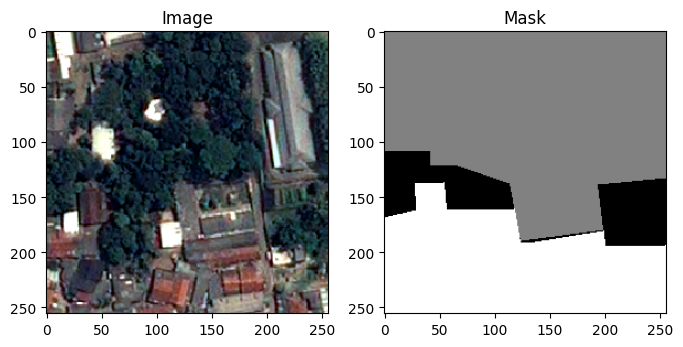

In [ ]:
# Sanity check, view few images
random.seed()
image_number = random.randint(0, len(images) - 1)

# Extract unique values and labels
unique_mask_values = get_unique_values([masks[image_number]])
unique_labels = get_unique_labels(unique_mask_values)

# Display unique labels and mask values
print("Unique Labels:", unique_labels)
print("Unique Mask Values:", unique_mask_values)

# Plot the images
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(images[image_number])
plt.title('Image')
plt.subplot(122)
plt.imshow(masks[image_number], cmap='gray')
plt.title('Mask')
plt.show()

## Debugging Unique Classes in Masks

In [ ]:
# Check unique values in masks and shape of masks
unique_values = np.unique(masks)
print("Unique values in masks:", unique_values)
print("Shape of masks array:", masks.shape)

# Ensure unique values in masks do not exceed the number of classes
n_classes = len(unique_values)
print("Number of classes:", n_classes)

Unique values in masks: [0.         0.14901961 0.29411766]
Shape of masks array: (5, 256, 256, 1)
Number of classes: 3


In [ ]:
# Determine Number of Unique Classes
unique_values = set()
for mask in masks:
    unique_values.update(np.unique(mask))
n_classes = len(unique_values) # Calculate based on unique values

masks_cat = to_categorical(masks, num_classes=n_classes)

## Optionally split into train/validation/test sets
x_train, x_val, y_train, y_val = train_test_split(images, masks_cat, test_size=0.2, random_state=42)

In [ ]:
# Determine Number of Unique Classes
n_classes = len(np.unique(masks))
masks_cat = to_categorical(masks, num_classes=n_classes)

## Optionally split into train/validation/test sets
x_train, x_val, y_train, y_val = train_test_split(images, masks_cat, test_size=0.2, random_state=42)

IndexError: index 38 is out of bounds for axis 1 with size 3

# U-Net Architecture

## Model Building

In [ ]:
# Function to build U-Net model
def unet_model(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    # Down-sampling path
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Up-sampling path
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4])
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3])
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2])
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1])
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', iou])  # Compile the model

    return model

## IoU Metric

In [ ]:
# Function to calculate Intersection over Union (IoU)
def iou(y_true, y_pred, smooth=1):
    y_true_f = tf.cast(tf.keras.backend.flatten(y_true), dtype=tf.float32)
    y_pred_f = tf.cast(tf.keras.backend.flatten(y_pred), dtype=tf.float32)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    union = tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

## Plot the Model Architecture

In [ ]:
# Function to calculate Dice Loss
def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

In [ ]:
model = unet_model()
#model.compile(optimizer='adam')
#model.compile(optimizer='adam', loss=total_loss)
#model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', iou])
model.summary()

In [ ]:
from tensorflow.keras.utils import plot_model
import numpy as np

plot_model(model,
           to_file='unet_model.png',
           show_shapes=True,
           show_layer_names=True)

# Load and rotate the image array
image = plt.imread('unet_model.png')
image_rotated = np.rot90(image)

# Display the rotated image
plt.figure(figsize=(20, 10))
plt.imshow(image_rotated)
plt.title('U-Net Model Architecture')
plt.axis('off')

plt.show()

## Model Training


In [ ]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Data augmentation for training
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True,
                             vertical_flip=True,
                             zoom_range=0.2)
datagen.fit(x_train)

# Train the model
history = model.fit(x_train, y_train,
                    validation_data=(x_val, y_val),
                    epochs=50,
                    batch_size=16,
                    callbacks=[early_stopping])

## Plot Training and Validation

In [ ]:
# Accuracy and Loss
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy over Epochs')
ax1.legend(['Train', 'Validation'], loc='upper right')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Loss over Epochs')
ax2.legend(['Train', 'Validation'], loc='upper right')

ax3.plot(history.history['iou'])
ax3.plot(history.history['val_iou'])
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')
ax3.set_title('IoU over Epochs')
ax3.legend(['Train', 'Validation'], loc='upper right')

plt.show()

In [ ]:
# Intersection over Union (IoU)
# Note: The IoU plot section had issues and seems to be plotting the same data as accuracy and loss.
# It would be best to calculate IoU correctly before plotting it. Assuming an accurate IoU calculation:
plt.plot(epochs, 'y', label='Train IoU')
plt.plot(epochs, 'r', label='Test IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.show()

# Model Evaluation and Testing

In [ ]:
# Evaluate the model
loss, accuracy, iou_score = model.evaluate(x_val, y_val)
print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")
print(f"Validation IoU: {iou_score}")

# Predict on a random test image
random_index = random.randint(0, len(x_val) - 1)
test_image = x_val[random_index]
test_mask = y_val[random_index]
predicted_mask = model.predict(np.expand_dims(test_image, axis=0)).squeeze()

# Get the corresponding file name
file_name = image_files[random_index]

# Plot the original image, ground truth mask, and predicted mask
plt.figure(figsize=(12, 5))

plt.subplot(131)
plt.imshow(test_image)
plt.title(f'{file_name}')

plt.subplot(132)
plt.imshow(test_mask, cmap='gray')
plt.title('Ground Truth Mask')

plt.subplot(133)
plt.imshow(predicted_mask, cmap='gray')
plt.title('Predicted Mask')

plt.show()